In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
import re
import sklearn

In [3]:
cols = ['sentiment','id','date','query_string','user','text']
df = pd.read_csv("data/sentiment140/training.csv",header=None, names=cols)
df[df.sentiment.isin([0,4])]
df = df.sample(10000, random_state=1234)
df.sentiment = df.sentiment.apply(lambda x: 'Negative' if x == 0 else 'Positive')

In [4]:
df

,sentiment,id,date,query_string,user,text
1062048,Positive,1964017646,Fri May 29 13:35:57 PDT 2009,NO_QUERY,ashakur,@PcShakur I guess so. We should go make it a f...
1236895,Positive,1992914899,Mon Jun 01 09:31:47 PDT 2009,NO_QUERY,RabbiShaiSpecht,@PsychicSophie Thank you!
1237054,Positive,1992954642,Mon Jun 01 09:35:38 PDT 2009,NO_QUERY,RobinRene7,it's just another day here at the office...I a...
229979,Negative,1978627799,Sat May 30 23:57:09 PDT 2009,NO_QUERY,valfvergara,@triciasays i miss kickboxing
760772,Negative,2296927988,Tue Jun 23 09:48:35 PDT 2009,NO_QUERY,SarahAnnGreen,@AmandaFClark Thats rubbish!
...,...,...,...,...,...,...
982398,Positive,1834201425,Mon May 18 02:01:12 PDT 2009,NO_QUERY,kirrawrr,today was sooo fun made videos with @angielilly
557203,Negative,2204457723,Wed Jun 17 02:16:04 PDT 2009,NO_QUERY,bridd,@DC_Zol looks like OS 3.0 will be released 10a...
692131,Negative,2252422682,Sat Jun 20 06:13:59 PDT 2009,NO_QUERY,astarmain,@broddo Saffer arm under the ball
1345176,Positive,2043953534,Fri Jun 05 08:39:25 PDT 2009,NO_QUERY,keiko25,So happy to have warm weather and sun!


# Préprocessing

accents, contractions, lowercase, newlines, lemmatization, stemming


In [5]:
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [6]:
import time
a = time.time()
# lowercase
df.text = df.text.apply(lambda x: x.lower())   

# remove extra newlines
df.text = df.text.apply(lambda x: re.sub(r'[\r|\n|\r\n]+', ' ', x))

# remove @tag
df.text = df.text.apply(lambda x: re.sub(r'@[A-Za-z0-9]+','', x))

# remove URL
df.text = df.text.apply(lambda x: re.sub('https?://[A-Za-z0-9./]+','', x))

# remove hashtag and numbers
df.text = df.text.apply(lambda x: re.sub("[^a-zA-Z]", " ", x))

# tokenization
df.text = df.text.apply(word_tokenize)

# # remove stop words
# stop_words = set(stopwords.words('english'))
# df.text = df.text.apply(lambda x: [word for word in x if word not in stop_words])

# lemmatization    
df.text = df.text.apply(nltk.tag.pos_tag)
df.text = df.text.apply(lambda x: [(word, get_wordnet_pos(pos_tag)) for (word, pos_tag) in x])

wordnet_lemmatizer = WordNetLemmatizer()
df.text = df.text.apply(lambda x: [wordnet_lemmatizer.lemmatize(word, tag) for (word, tag) in x])


df.text = df.text.apply(lambda x: ' '.join(word for word in x))
df
print(time.time()-a)

12.58809208869934


In [7]:
df

,sentiment,id,date,query_string,user,text
1062048,Positive,1964017646,Fri May 29 13:35:57 PDT 2009,NO_QUERY,ashakur,i guess so we should go make it a family affair
1236895,Positive,1992914899,Mon Jun 01 09:31:47 PDT 2009,NO_QUERY,RabbiShaiSpecht,thank you
1237054,Positive,1992954642,Mon Jun 01 09:35:38 PDT 2009,NO_QUERY,RobinRene7,it s just another day here at the office i be ...
229979,Negative,1978627799,Sat May 30 23:57:09 PDT 2009,NO_QUERY,valfvergara,i miss kickboxing
760772,Negative,2296927988,Tue Jun 23 09:48:35 PDT 2009,NO_QUERY,SarahAnnGreen,thats rubbish
...,...,...,...,...,...,...
982398,Positive,1834201425,Mon May 18 02:01:12 PDT 2009,NO_QUERY,kirrawrr,today be sooo fun make video with
557203,Negative,2204457723,Wed Jun 17 02:16:04 PDT 2009,NO_QUERY,bridd,zol look like o will be release be pacific tim...
692131,Negative,2252422682,Sat Jun 20 06:13:59 PDT 2009,NO_QUERY,astarmain,saffer arm under the ball
1345176,Positive,2043953534,Fri Jun 05 08:39:25 PDT 2009,NO_QUERY,keiko25,so happy to have warm weather and sun


# Term frequency

In [8]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()

vectorizer.fit(df.text)

neg_matrix = vectorizer.transform(df[df.sentiment == 'Negative'].text)
pos_matrix = vectorizer.transform(df[df.sentiment == 'Positive'].text)

In [9]:
print(df[df.sentiment == 'Negative'].iloc[1].text)
print(neg_matrix[1])
liste = vectorizer.get_feature_names()
print([liste[i] for i in neg_matrix[1].tocoo().col])


thats rubbish
  (0, 8604)	1
  (0, 10037)	1
['rubbish', 'thats']


In [10]:
neg_tf = np.sum(neg_matrix,axis=0)
pos_tf = np.sum(pos_matrix,axis=0)
neg = np.squeeze(np.asarray(neg_tf))
pos = np.squeeze(np.asarray(pos_tf))

term_freq_df = pd.DataFrame([neg,pos],
                            columns=vectorizer.get_feature_names()
                           ).transpose()
term_freq_df.columns = ['negative', 'positive']
term_freq_df['total'] = term_freq_df['negative'] + term_freq_df['positive']
term_freq_df.sort_values(by='total', 
                         ascending=False
                        ).iloc[:10]

,negative,positive,total
be,2230,1891,4121
to,1925,1549,3474
the,1613,1671,3284
it,1156,967,2123
my,1211,746,1957
and,964,935,1899
you,597,1238,1835
have,914,685,1599
in,744,655,1399
for,612,743,1355


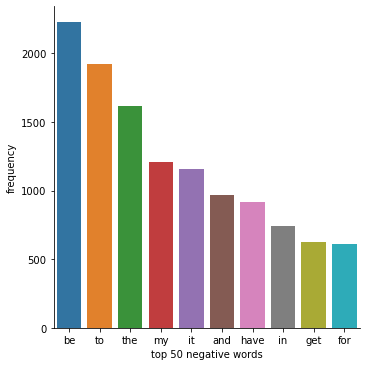

In [11]:
df1 = term_freq_df.sort_values(by='negative', ascending=False).head(10)
g = sns.catplot(x='index', y="negative", kind='bar', data=df1.reset_index())
g.set_axis_labels('top 50 negative words', 'frequency')
plt.show()

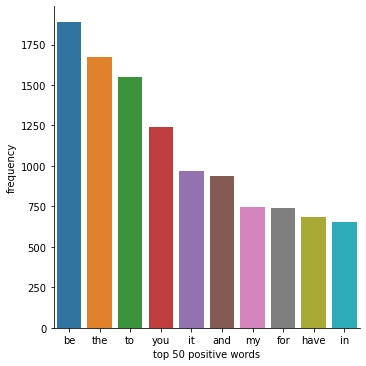

In [12]:
df2 = term_freq_df.sort_values(by='positive', ascending=False).head(10)
g = sns.catplot(x='index', y="positive", kind='bar', data=df2.reset_index())
g.set_axis_labels('top 50 positive words', 'frequency')
plt.show()

# Linear Classifier

In [13]:
vectorizer = CountVectorizer()

X = df.text.to_list()
Y = df.sentiment.to_list()

X_vec = vectorizer.fit_transform(X).toarray()

In [14]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test  = train_test_split(
        X_vec, 
        Y,
        train_size=0.80,
        random_state=1234)

In [15]:
from sklearn.linear_model import LogisticRegression
log_model= LogisticRegression()
log_model.fit(X_train, y_train)
y_pred = log_model.predict(X_test)

C:\Users\pasqu\anaconda3\envs\data-2A\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [16]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, y_pred)

array([[731, 239],
       [245, 785]], dtype=int64)

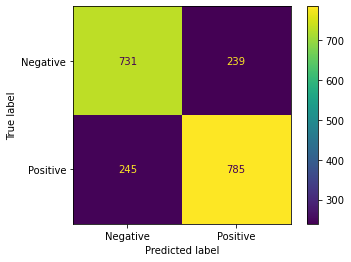

Accuracy : 0.758
Recall : 0.7666015625
Precision : 0.7621359223300971
F1 : 0.7643622200584227


In [17]:
sc_accuracy = sklearn.metrics.accuracy_score(y_pred, y_test)
sc_f1 = sklearn.metrics.f1_score(y_pred, y_test, pos_label="Positive")
sc_recall = sklearn.metrics.recall_score(y_pred, y_test, pos_label="Positive")
sc_precision = sklearn.metrics.precision_score(y_pred, y_test, pos_label="Positive")

sklearn.metrics.plot_confusion_matrix(log_model, X_test, y_test)
plt.show()

print(f"Accuracy : {sc_accuracy}")
print(f"Recall : {sc_recall}")
print(f"Precision : {sc_precision}")
print(f"F1 : {sc_f1}")

In [18]:
'''
import random
j = random.randint(0,len(X_test)-7)
for i in range(j,j+7):
    print(y_pred[i])
    ind = X_vec.tolist().index(X_test[i].tolist())
    print(X[ind].strip())
'''

'\nimport random\nj = random.randint(0,len(X_test)-7)\nfor i in range(j,j+7):\n    print(y_pred[i])\n    ind = X_vec.tolist().index(X_test[i].tolist())\n    print(X[ind].strip())\n'